In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from datetime import timedelta
from sklearn.model_selection import train_test_split
import io
import base64
from matplotlib.figure import Figure
import os
from django.conf import settings

In [268]:
company_code = 'ADIN'
company_and_names = pd.read_csv('stockapp/data/company_codes_and_names.csv')

# Find company ID based on code
company_info = company_and_names[company_and_names['Company_Code'] == company_code]
if company_info.empty:
    raise ValueError(f"Company code {company_code} not found in company_codes_and_names.csv")
company_id = company_info['Company_ID'].values[0]


df = pd.read_csv('stockapp/data/data_for_models.csv')

# Filter data for the specific company
df = df[df['company_id'] == company_id]

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2698 entries, 20481 to 23178
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_id        2698 non-null   int64  
 1   date              2698 non-null   object 
 2   last_transaction  2698 non-null   float64
 3   max_price         210 non-null    float64
 4   min_price         210 non-null    float64
 5   average_price     2698 non-null   float64
 6   volume            2698 non-null   float64
 7   BEST_profit       2698 non-null   float64
 8   total_profit      2698 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 210.8+ KB


In [270]:
df.head()

,company_id,date,last_transaction,max_price,min_price,average_price,volume,BEST_profit,total_profit
20481,1,2014-12-30,357.0,NaN,NaN,357.0,0.0,0.0,0.0
20482,1,2014-12-29,357.0,NaN,NaN,357.0,0.0,0.0,0.0
20483,1,2014-12-26,357.0,NaN,NaN,357.0,0.0,0.0,0.0
20484,1,2014-12-25,357.0,NaN,NaN,357.0,0.0,0.0,0.0
20485,1,2014-12-24,357.0,NaN,NaN,357.0,0.0,0.0,0.0


In [271]:
df['date'] = pd.to_datetime(df['date'])

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2698 entries, 20481 to 23178
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   company_id        2698 non-null   int64         
 1   date              2698 non-null   datetime64[ns]
 2   last_transaction  2698 non-null   float64       
 3   max_price         210 non-null    float64       
 4   min_price         210 non-null    float64       
 5   average_price     2698 non-null   float64       
 6   volume            2698 non-null   float64       
 7   BEST_profit       2698 non-null   float64       
 8   total_profit      2698 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 210.8 KB


In [273]:
#ascending=False
df = df.sort_values(by='date')

In [274]:
df.tail(10)

,company_id,date,last_transaction,max_price,min_price,average_price,volume,BEST_profit,total_profit
22945,1,2024-12-16,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22944,1,2024-12-17,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22943,1,2024-12-18,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22942,1,2024-12-19,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22941,1,2024-12-20,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22940,1,2024-12-23,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22939,1,2024-12-24,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22938,1,2024-12-25,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22937,1,2024-12-26,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0
22936,1,2024-12-27,1650.0,NaN,NaN,1650.0,0.0,0.0,0.0


In [275]:
df = df[['date', 'average_price', 'volume', 'max_price', 'min_price']].copy()

In [276]:
# Handle missing values if any
df.bfill(inplace=True)
df.ffill(inplace=True)

In [277]:
"""
 # Check if we have enough data for LSTM (at least 60 records)
if len(df) < 60:
    # If there are less than 60 records, predict the last value repeated 7 times
    last_row = df.iloc[-1]
    next_7_days = pd.date_range(last_row['date'] + timedelta(days=1), periods=7, freq='D')

    # Repeat the last known values for the next 7 days
    next_7_days_data = {
        'date': next_7_days,
        'average_price': [last_row['average_price']] * 7,
        'volume': [last_row['volume']] * 7,
        'max_price': [last_row['max_price']] * 7,
        'min_price': [last_row['min_price']] * 7
    }

    next_7_days_df = pd.DataFrame(next_7_days_data)

    # Plotting the prediction (same value repeated)
    plt.figure(figsize=(12, 6))

    plt.plot(df['date'], df['average_price'], label='Историски цени', color='blue')
    plt.plot(next_7_days_df['date'], next_7_days_df['average_price'], label='Предвидени цени (Наредни 7 денови)', color='green', linestyle='--')

    # Add plot labels and title
    plt.xlabel('Датум')
    plt.ylabel('Цена на акција')
    plt.title(f'Недоволно податоци за LSTM: Последни 7 денови за {company_code}', color='red')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()



    # Save the plot to BytesIO and encode it for use in the web page
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    encoded_image = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()

    # Return base64-encoded image
    return f"data:image/png;base64,{encoded_image}"
else:
    print(df.isna().sum())
"""

'\n # Check if we have enough data for LSTM (at least 60 records)\nif len(df) < 60:\n    # If there are less than 60 records, predict the last value repeated 7 times\n    last_row = df.iloc[-1]\n    next_7_days = pd.date_range(last_row[\'date\'] + timedelta(days=1), periods=7, freq=\'D\')\n\n    # Repeat the last known values for the next 7 days\n    next_7_days_data = {\n        \'date\': next_7_days,\n        \'average_price\': [last_row[\'average_price\']] * 7,\n        \'volume\': [last_row[\'volume\']] * 7,\n        \'max_price\': [last_row[\'max_price\']] * 7,\n        \'min_price\': [last_row[\'min_price\']] * 7\n    }\n\n    next_7_days_df = pd.DataFrame(next_7_days_data)\n\n    # Plotting the prediction (same value repeated)\n    plt.figure(figsize=(12, 6))\n\n    plt.plot(df[\'date\'], df[\'average_price\'], label=\'Историски цени\', color=\'blue\')\n    plt.plot(next_7_days_df[\'date\'], next_7_days_df[\'average_price\'], label=\'Предвидени цени (Наредни 7 денови)\', color=\

In [278]:
print(df.isna().sum())

date             0
average_price    0
volume           0
max_price        0
min_price        0
dtype: int64


In [279]:
df.head(10)

,date,average_price,volume,max_price,min_price
20727,2014-01-02,250.0,0.0,251.0,251.0
20726,2014-01-03,250.0,0.0,251.0,251.0
20725,2014-01-08,250.0,0.0,251.0,251.0
20724,2014-01-09,250.0,0.0,251.0,251.0
20723,2014-01-10,250.0,0.0,251.0,251.0
20722,2014-01-13,250.0,0.0,251.0,251.0
20721,2014-01-14,250.0,0.0,251.0,251.0
20720,2014-01-15,250.0,0.0,251.0,251.0
20719,2014-01-16,250.0,0.0,251.0,251.0
20718,2014-01-17,250.0,0.0,251.0,251.0


In [280]:
# Normalize the 'average_price' to be between 0 and 1 (for LSTM)
#scaler = MinMaxScaler(feature_range=(0, 1))
#df['average_price'] = scaler.fit_transform(df['average_price'].values.reshape(-1, 1))

In [281]:
# Set date as index for time series data
#df.set_index('date', inplace=True)

In [282]:
df.sample(10)

,date,average_price,volume,max_price,min_price
22840,2023-05-25,722.0,0.0,850.0,850.0
21916,2019-02-22,660.0,0.0,691.0,691.0
22431,2021-01-27,690.0,0.0,701.0,701.0
23173,2024-01-10,1000.0,0.0,1200.0,1200.0
23073,2024-06-10,1690.0,0.0,1600.0,1600.0
21333,2017-07-10,680.0,0.0,659.0,659.0
21496,2018-11-08,618.0,0.0,700.0,700.0
20951,2015-02-03,367.0,396.0,367.0,367.0
23160,2024-01-30,1000.0,0.0,1200.0,1200.0
21823,2019-07-11,679.0,0.0,620.0,620.0


In [283]:
# Get time_step amount of data
#df = df.head(time_step)

In [284]:
# Calculate the minimum and maximum date
#min_date = df['date'].min()
#max_date = df['date'].max()

min_date = pd.to_datetime(df['date'].min())
max_date = pd.to_datetime(df['date'].max())

# Scale the dates to a range between 0 and 1
df['scaled_date'] = (df['date'] - min_date) / (max_date - min_date)

In [285]:
df.head(10)

,date,average_price,volume,max_price,min_price,scaled_date
20727,2014-01-02,250.0,0.0,251.0,251.0,0.000000
20726,2014-01-03,250.0,0.0,251.0,251.0,0.000249
20725,2014-01-08,250.0,0.0,251.0,251.0,0.001496
20724,2014-01-09,250.0,0.0,251.0,251.0,0.001745
20723,2014-01-10,250.0,0.0,251.0,251.0,0.001994
20722,2014-01-13,250.0,0.0,251.0,251.0,0.002742
20721,2014-01-14,250.0,0.0,251.0,251.0,0.002991
20720,2014-01-15,250.0,0.0,251.0,251.0,0.003240
20719,2014-01-16,250.0,0.0,251.0,251.0,0.003490
20718,2014-01-17,250.0,0.0,251.0,251.0,0.003739


In [286]:
# Get features and target
X, y = df.drop(['average_price', 'date'], axis=1), df['average_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [287]:
# Apply MinMaxScaler to scale the features (fit on training set, transform both train and test sets)
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = x_scaler.transform(X_test)    

# Reshape the data for LSTM input format: [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])  # [samples, time steps, features]
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])     # [samples, time steps, features]

In [288]:
# Apply MinMaxScaler to scale the target variable (fit on training set, transform both train and test sets)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))  # Fit and transform on training set
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [289]:
# Check the shapes of the reshaped data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

X_train_scaled shape: (1888, 1, 4)
X_test_scaled shape: (810, 1, 4)
y_train_scaled shape: (1888, 1)
y_test_scaled shape: (810, 1)


In [290]:
model = Sequential([
    Input((X_train_scaled.shape[1], X_train_scaled.shape[2],)),
    LSTM(50, return_sequences=True),
    Dropout(0.4),
    LSTM(50, return_sequences=False),
    Dropout(0.4),
    Dense(25),
    Dense(1)
])


In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2698 entries, 20727 to 22936
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2698 non-null   datetime64[ns]
 1   average_price  2698 non-null   float64       
 2   volume         2698 non-null   float64       
 3   max_price      2698 non-null   float64       
 4   min_price      2698 non-null   float64       
 5   scaled_date    2698 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 147.5 KB


In [292]:
print(df.dtypes)

date             datetime64[ns]
average_price           float64
volume                  float64
max_price               float64
min_price               float64
scaled_date             float64
dtype: object


In [293]:
print(df.isna().sum())

date             0
average_price    0
volume           0
max_price        0
min_price        0
scaled_date      0
dtype: int64


In [294]:
print(df.describe())

                                date  average_price        volume  \
count                           2698    2698.000000   2698.000000   
mean   2019-07-01 14:31:34.736841984     657.696761     31.401038   
min              2014-01-02 00:00:00     243.000000      0.000000   
25%              2016-09-30 18:00:00     409.250000      0.000000   
50%              2019-07-02 12:00:00     660.000000      0.000000   
75%              2022-03-28 18:00:00     731.000000      0.000000   
max              2024-12-27 00:00:00    1800.000000  18308.000000   
std                              NaN     325.733964    410.011547   

         max_price    min_price  scaled_date  
count  2698.000000  2698.000000  2698.000000  
mean    676.327279   676.075612     0.500151  
min     243.000000   243.000000     0.000000  
25%     450.000000   450.000000     0.249938  
50%     659.000000   659.000000     0.500374  
75%     750.000000   750.000000     0.749688  
max    1800.000000  1800.000000     1.000000  
st

In [295]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [296]:
# Step 6: Train the model
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=10, batch_size=64, verbose=1)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0880 - val_loss: 0.0265
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0093
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0030


In [297]:
# Step 7: Make predictions on the test set
predictions = model.predict(X_test_scaled)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [298]:
from sklearn.metrics import mean_squared_error

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss (MSE): {test_loss}")

# Alternatively, calculate Mean Squared Error (MSE) manually
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error (MSE): {mse}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 
Test Loss (MSE): 0.002979400334879756
Mean Squared Error (MSE): 0.0029793999915671337


In [299]:
print(X_test)

       volume  max_price  min_price  scaled_date
21839     0.0      679.0      679.0     0.497009
21463     0.0      660.0      660.0     0.453141
21579     0.0      558.0      558.0     0.411266
21382     0.0      680.0      680.0     0.301595
21947     0.0      660.0      660.0     0.457129
...       ...        ...        ...          ...
21150     0.0      299.0      299.0     0.205882
21725     0.0      600.0      600.0     0.538634
22165     0.0      600.0      600.0     0.558325
21760     0.0      600.0      600.0     0.526171
23022     0.0     1610.0     1610.0     0.968345

[810 rows x 4 columns]


In [300]:
# Inverse transform the predictions to get them back to the original price range
predictions_original = y_scaler.inverse_transform(predictions)

# Access scaled dates from the first column of X_test
scaled_dates = X_test.iloc[:, -1]  # Access the last column (scaled_date)

# Convert the scaled dates back to actual dates
actual_dates = min_date + pd.to_timedelta(scaled_dates * (max_date - min_date), unit='D')

# Print the actual dates
print(actual_dates)

21839   2019-06-19 00:00:00.000000000
21463   2018-12-25 00:00:00.000000000
21579   2018-07-10 00:00:00.000000000
21382   2017-04-26 00:00:00.000000000
21947   2019-01-10 00:00:00.000000000
                     ...             
21150   2016-04-07 00:00:00.000000000
21725   2019-12-02 23:59:59.999999968
22165   2020-02-20 00:00:00.000000000
21760   2019-10-14 00:00:00.000000000
23022   2024-08-22 00:00:00.000000000
Name: scaled_date, Length: 810, dtype: datetime64[ns]


In [301]:
print(X_test.columns)

Index(['volume', 'max_price', 'min_price', 'scaled_date'], dtype='object')


In [302]:
print(X_test.iloc[:, 0])

21839    0.0
21463    0.0
21579    0.0
21382    0.0
21947    0.0
        ... 
21150    0.0
21725    0.0
22165    0.0
21760    0.0
23022    0.0
Name: volume, Length: 810, dtype: float64


In [303]:
print(X_test.shape)

(810, 4)


In [304]:
print(actual_dates)

21839   2019-06-19 00:00:00.000000000
21463   2018-12-25 00:00:00.000000000
21579   2018-07-10 00:00:00.000000000
21382   2017-04-26 00:00:00.000000000
21947   2019-01-10 00:00:00.000000000
                     ...             
21150   2016-04-07 00:00:00.000000000
21725   2019-12-02 23:59:59.999999968
22165   2020-02-20 00:00:00.000000000
21760   2019-10-14 00:00:00.000000000
23022   2024-08-22 00:00:00.000000000
Name: scaled_date, Length: 810, dtype: datetime64[ns]


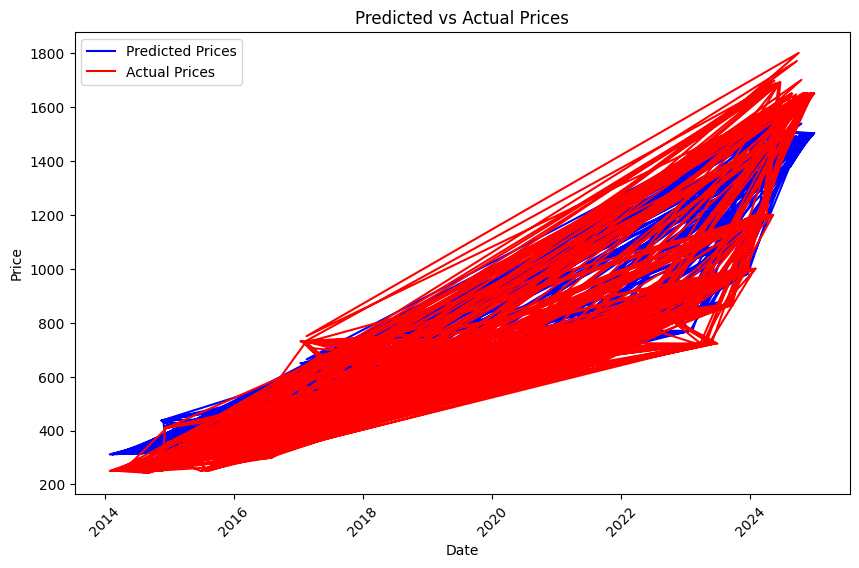

In [305]:
plt.figure(figsize=(10, 6))
plt.plot(actual_dates, predictions_original, label='Predicted Prices', color='blue')
plt.plot(actual_dates, y_test, label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


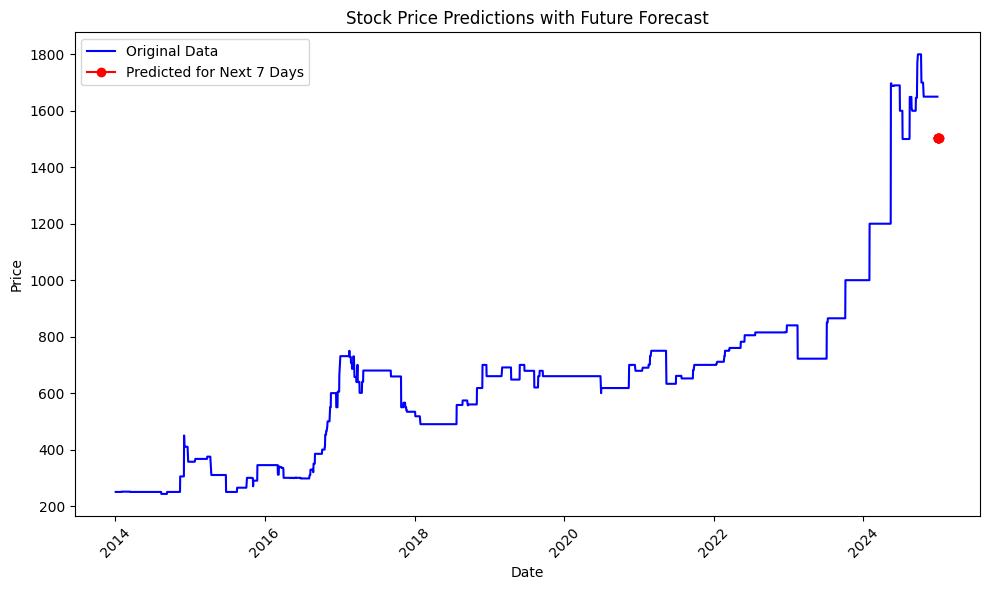

In [306]:
# Step 1: Get the last 7 days from the original data
last_7_days = df.tail(7)
last_date = df['date'].iloc[-1]

# Calculate the next 7 days by extrapolating based on the recent trend
price_diff_max = (last_7_days['max_price'].iloc[-1] - last_7_days['max_price'].iloc[0]) / len(last_7_days)
price_diff_min = (last_7_days['min_price'].iloc[-1] - last_7_days['min_price'].iloc[0]) / len(last_7_days)
price_diff_avg = (last_7_days['average_price'].iloc[-1] - last_7_days['average_price'].iloc[0]) / len(last_7_days)
volume_diff = (last_7_days['volume'].iloc[-1] - last_7_days['volume'].iloc[0]) / len(last_7_days)

next_7_days_max = [last_7_days['max_price'].iloc[-1] + price_diff_max * (i + 1) for i in range(7)]
next_7_days_min = [last_7_days['min_price'].iloc[-1] + price_diff_min * (i + 1) for i in range(7)]
next_7_days_avg = [last_7_days['average_price'].iloc[-1] + price_diff_avg * (i + 1) for i in range(7)]
next_7_days_volume = [last_7_days['volume'].iloc[-1] + volume_diff * (i + 1) for i in range(7)]

# Generate the dates for the next 7 days
next_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7, freq='D')

# Scale the next dates
next_dates_scaled = (next_dates - min_date).days / (max_date - min_date).days

# Create the DataFrame for the next 7 days
next_7_days_df = pd.DataFrame({
    'volume': next_7_days_volume,
    'max_price': next_7_days_max,
    'min_price': next_7_days_min,
    'scaled_date': next_dates_scaled
})

# Step 2: Scale the new data (X) using the x_scaler
next_7_days_scaled = x_scaler.transform(next_7_days_df[['volume', 'max_price', 'min_price', 'scaled_date']])

# Step 3: Reshape the scaled data for the model
next_7_days_features_reshaped = next_7_days_scaled.reshape(
    (next_7_days_scaled.shape[0], 1, next_7_days_scaled.shape[1])
)

# Step 4: Make predictions using the model
next_7_days_predictions_scaled = model.predict(next_7_days_features_reshaped)

# Step 5: If y was scaled, inverse transform the predictions
next_7_days_predictions_original = y_scaler.inverse_transform(next_7_days_predictions_scaled)

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['average_price'], label="Original Data", color='blue')
plt.plot(next_dates, next_7_days_predictions_original, label="Predicted for Next 7 Days", color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Predictions with Future Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [307]:
print(predictions_original)

[[ 665.85144]
 [ 643.86066]
 [ 570.7743 ]
 [ 622.9096 ]
 [ 644.7523 ]
 [ 376.58548]
 [ 612.43463]
 [ 521.1994 ]
 [ 683.191  ]
 [ 504.2598 ]
 [ 629.1679 ]
 [ 380.84283]
 [ 862.1593 ]
 [ 566.4082 ]
 [ 978.48035]
 [ 572.07043]
 [ 615.3888 ]
 [ 627.3877 ]
 [ 565.4508 ]
 [ 614.34875]
 [ 864.2325 ]
 [ 396.28763]
 [ 628.685  ]
 [ 667.6413 ]
 [ 628.222  ]
 [ 696.9149 ]
 [ 385.0575 ]
 [ 847.9385 ]
 [ 343.33926]
 [ 566.62354]
 [ 630.12854]
 [ 622.5575 ]
 [ 615.16974]
 [ 770.72986]
 [1518.9148 ]
 [1520.1376 ]
 [ 695.95795]
 [ 379.52518]
 [ 568.6706 ]
 [ 334.27704]
 [ 332.1446 ]
 [ 769.12634]
 [ 370.16922]
 [ 740.91534]
 [ 345.3436 ]
 [ 393.63455]
 [ 691.38885]
 [ 395.20706]
 [ 860.51404]
 [ 389.81824]
 [ 377.78143]
 [ 399.5949 ]
 [1520.7131 ]
 [ 820.75653]
 [ 849.21216]
 [1500.2333 ]
 [ 395.6981 ]
 [1517.3271 ]
 [ 384.83823]
 [ 519.77606]
 [ 729.2589 ]
 [ 552.86743]
 [ 352.78528]
 [ 630.0586 ]
 [ 432.0152 ]
 [ 685.983  ]
 [ 643.80493]
 [ 613.4473 ]
 [ 411.84537]
 [ 770.04205]
 [ 385.37778]
 [ 311

In [308]:
print(y_scaler.inverse_transform(next_7_days_predictions_scaled))

[[1502.9524]
 [1503.024 ]
 [1503.0953]
 [1503.1672]
 [1503.2388]
 [1503.3102]
 [1503.3818]]


In [309]:
last_7_days

,date,average_price,volume,max_price,min_price,scaled_date
22942,2024-12-19,1650.0,0.0,1650.0,1650.0,0.998006
22941,2024-12-20,1650.0,0.0,1650.0,1650.0,0.998255
22940,2024-12-23,1650.0,0.0,1650.0,1650.0,0.999003
22939,2024-12-24,1650.0,0.0,1650.0,1650.0,0.999252
22938,2024-12-25,1650.0,0.0,1650.0,1650.0,0.999501
22937,2024-12-26,1650.0,0.0,1650.0,1650.0,0.999751
22936,2024-12-27,1650.0,0.0,1650.0,1650.0,1.000000


In [310]:
last_date

Timestamp('2024-12-27 00:00:00')

In [311]:
print(df.tail(7))
print(next_7_days_df)

            date  average_price  volume  max_price  min_price  scaled_date
22942 2024-12-19         1650.0     0.0     1650.0     1650.0     0.998006
22941 2024-12-20         1650.0     0.0     1650.0     1650.0     0.998255
22940 2024-12-23         1650.0     0.0     1650.0     1650.0     0.999003
22939 2024-12-24         1650.0     0.0     1650.0     1650.0     0.999252
22938 2024-12-25         1650.0     0.0     1650.0     1650.0     0.999501
22937 2024-12-26         1650.0     0.0     1650.0     1650.0     0.999751
22936 2024-12-27         1650.0     0.0     1650.0     1650.0     1.000000
   volume  max_price  min_price  scaled_date
0     0.0     1650.0     1650.0     1.000249
1     0.0     1650.0     1650.0     1.000499
2     0.0     1650.0     1650.0     1.000748
3     0.0     1650.0     1650.0     1.000997
4     0.0     1650.0     1650.0     1.001246
5     0.0     1650.0     1650.0     1.001496
6     0.0     1650.0     1650.0     1.001745


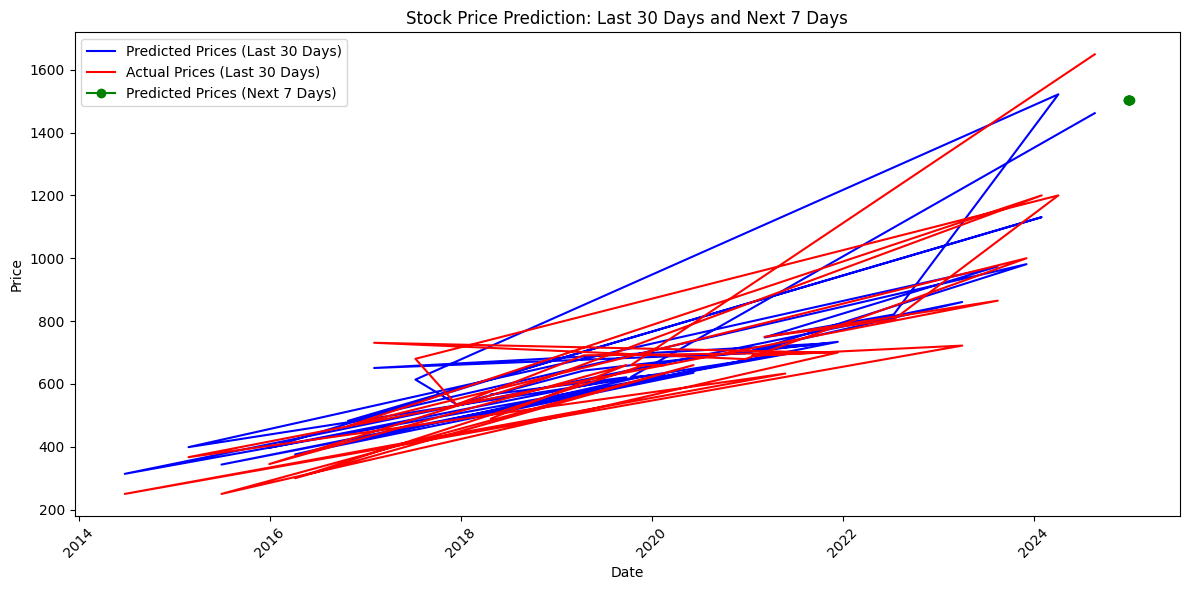

In [312]:
# Prepare the actual dates for plotting
actual_dates = min_date + pd.to_timedelta(X_test['scaled_date'] * (max_date - min_date).days, unit='D')

# Limit the displayed data to the last 30 days of the test set
last_30_indices = -30 if len(actual_dates) > 30 else -len(actual_dates)
actual_dates_last_30 = actual_dates[last_30_indices:]
predictions_original_last_30 = predictions_original[last_30_indices:]
y_test_last_30 = y_test.values[last_30_indices:]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the last 30 days of test data predictions
plt.plot(actual_dates_last_30, predictions_original_last_30, label='Predicted Prices (Last 30 Days)', color='blue')
plt.plot(actual_dates_last_30, y_test_last_30, label='Actual Prices (Last 30 Days)', color='red')

# Add next 7 days' predictions
plt.plot(next_dates, next_7_days_predictions_original, label="Predicted Prices (Next 7 Days)", color='green', marker='o')

# Add plot labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction: Last 30 Days and Next 7 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


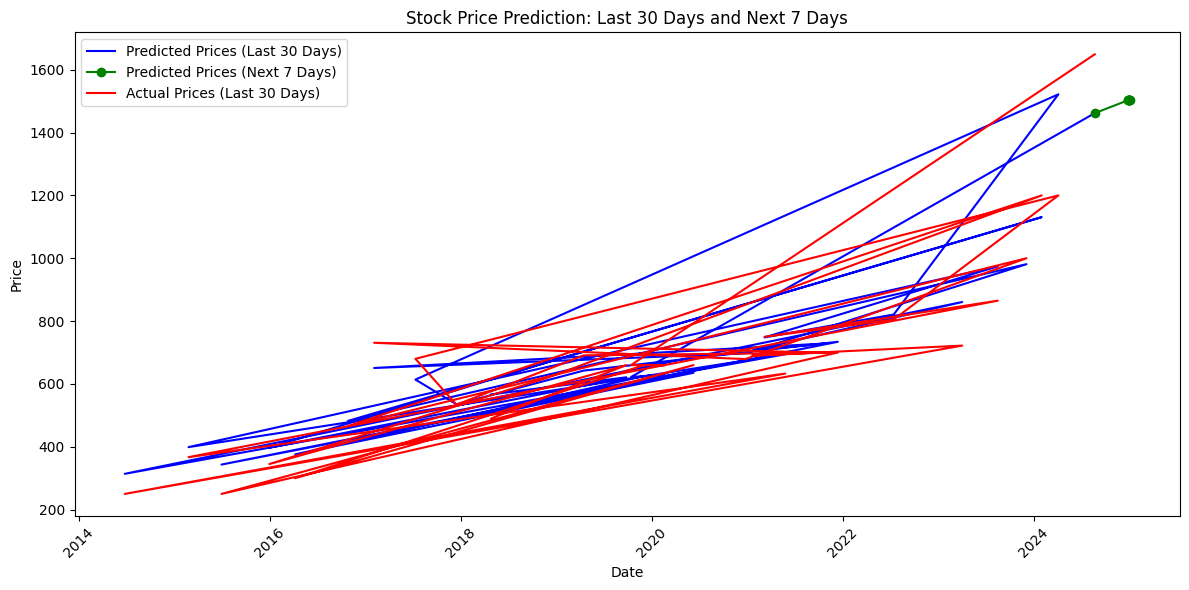

In [313]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot the last 30 days of test data predictions
plt.plot(actual_dates_last_30, predictions_original_last_30, label='Predicted Prices (Last 30 Days)', color='blue')

# Connect the first dot of next 7 days' predictions with the last predicted price of the last 30 days
next_dates_with_connection = [actual_dates_last_30.iloc[-1]] + next_dates.tolist()  # Add the last date of last 30 days to next_dates
next_7_days_predictions_with_connection = [predictions_original_last_30[-1]] + next_7_days_predictions_original.tolist()  # Add the last prediction of the last 30 days to next predictions

# Plot next 7 days' predictions with the first dot connected
plt.plot(next_dates_with_connection, next_7_days_predictions_with_connection, label="Predicted Prices (Next 7 Days)", color='green', marker='o')

# Plot actual prices for the last 30 days
plt.plot(actual_dates_last_30, y_test_last_30, label='Actual Prices (Last 30 Days)', color='red')

# Add plot labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction: Last 30 Days and Next 7 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


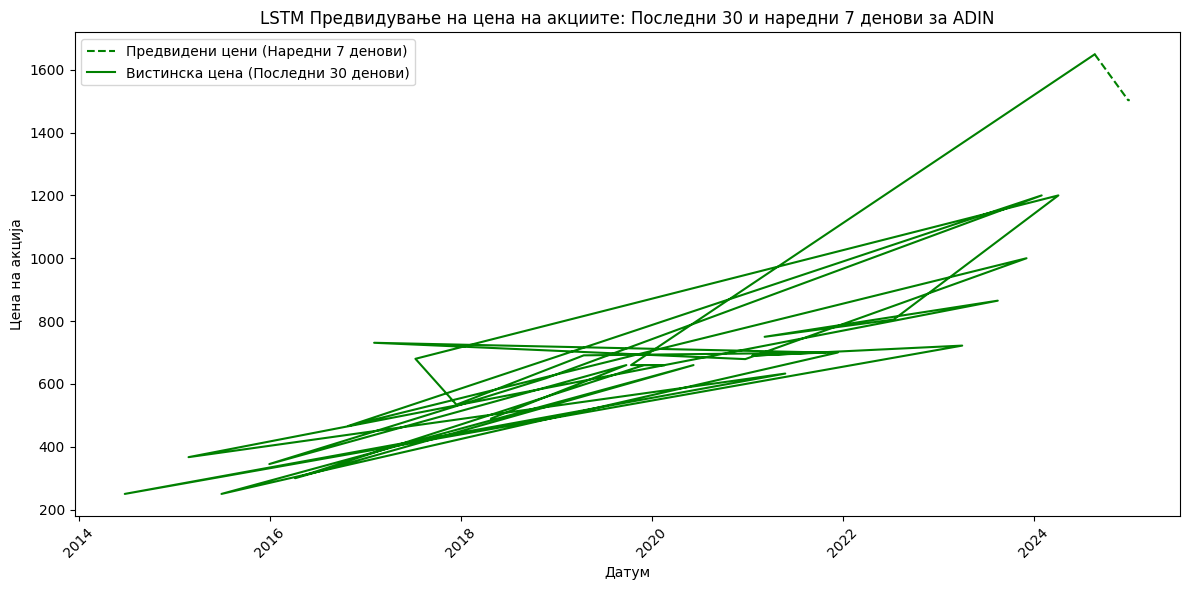

In [314]:
# Ensure next_dates and next_7_days_predictions_original are 1D arrays
next_dates = np.array(next_dates).flatten()
next_7_days_predictions_original = np.array(next_7_days_predictions_original).flatten()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the last 30 days of test data predictions with reduced opacity (alpha=0.25)
#plt.plot(actual_dates_last_30, predictions_original_last_30, label='Предвидени цени (Последни 30 денови)', color='red', alpha=0.25)

# Connect the first dot of next 7 days' predictions with the last actual price of the last 30 days
# Ensure the next_dates and next_7_days_predictions_original are 1D and have compatible shapes
next_dates_with_connection = [actual_dates_last_30.iloc[-1]] + list(next_dates)  # Add the last date of last 30 days to next_dates
next_7_days_predictions_with_connection = [y_test_last_30[-1]] + list(next_7_days_predictions_original)  # Add the last actual price to next predictions

# Plot next 7 days' predictions with the first dot connected to the actual price
plt.plot(next_dates_with_connection, next_7_days_predictions_with_connection, label="Предвидени цени (Наредни 7 денови)", color='green', linestyle='--')

# Plot actual prices for the last 30 days
plt.plot(actual_dates_last_30, y_test_last_30, label='Вистинска цена (Последни 30 денови)', color='green')

# Add plot labels and title
plt.xlabel('Датум')
plt.ylabel('Цена на акција')
plt.title(f'LSTM Предвидување на цена на акциите: Последни 30 и наредни 7 денови за {company_code}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
#plt.figtext(0.5, 0.01, 'Имајте во предвид дека информациите за наредните денови се автоматски генерирани и не се вистинити!', ha='center', fontsize=10, color='red')
# Show the plot
plt.show()


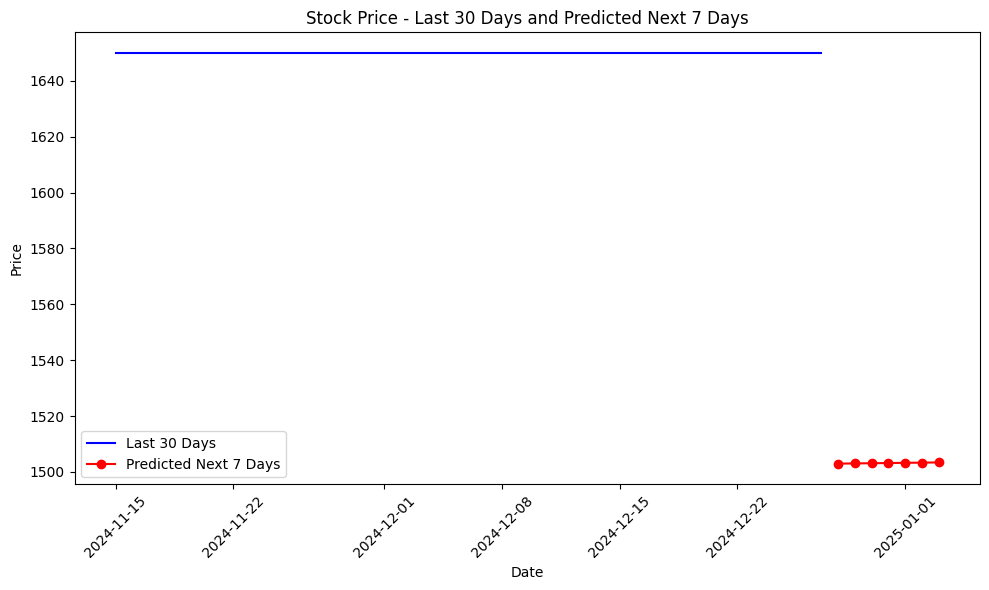

In [315]:
# 1. Plot the last 30 days from the original data (actual prices)
last_30_days = df.tail(30)

# 2. Generate the dates for the next 7 days of predictions
next_dates = pd.date_range(last_30_days['date'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

# Assuming next_7_days_predictions_original is already in its original scale
# 3. Plot the original data (last 30 days) and predictions (next 7 days)
plt.figure(figsize=(10, 6))

# Plot the last 30 days of actual data
plt.plot(last_30_days['date'], last_30_days['average_price'], label="Last 30 Days", color='blue')

# Plot the next 7 days of predicted data
plt.plot(next_dates, next_7_days_predictions_original, label="Predicted Next 7 Days", color='red', marker='o')

# Labeling the axes and the title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price - Last 30 Days and Predicted Next 7 Days')

# Formatting the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Show the legend and the plot
plt.legend()
plt.show()

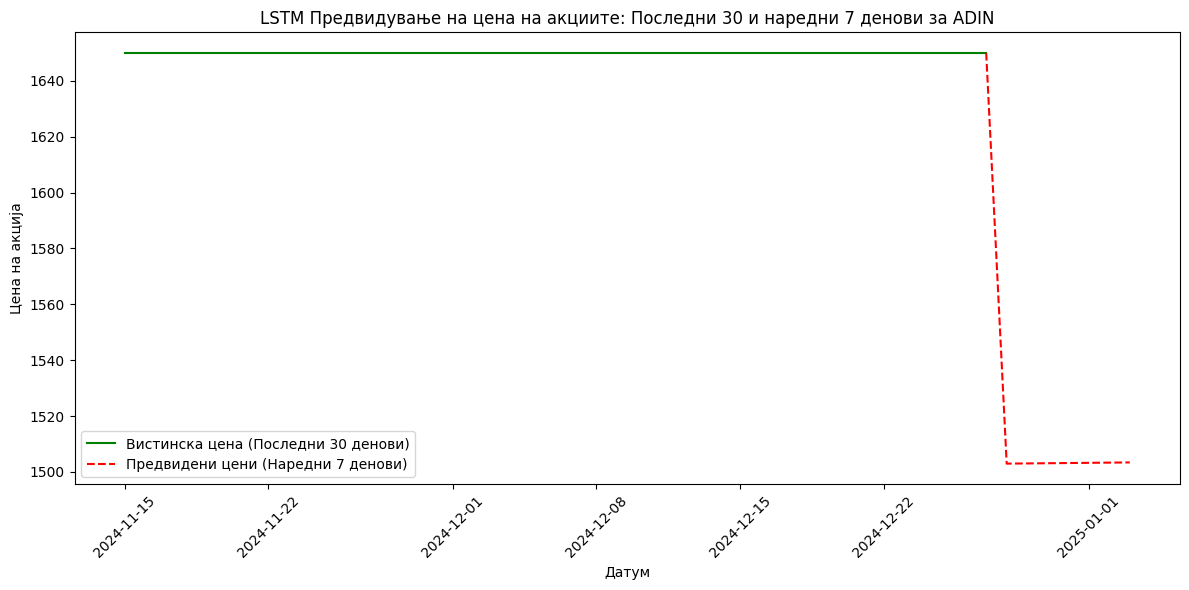

In [316]:

# Ensure next_dates and next_7_days_predictions_original are 1D arrays
next_dates = np.array(next_dates).flatten()
next_7_days_predictions_original = np.array(next_7_days_predictions_original).flatten()

# Get the last 30 days of actual data
actual_dates_last_30 = df['date'].iloc[-30:].values  # Assuming df is your main data DataFrame
y_test_last_30 = df['average_price'].iloc[-30:].values  # Assuming 'average_price' is the column you want

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual prices for the last 30 days
plt.plot(actual_dates_last_30, y_test_last_30, label='Вистинска цена (Последни 30 денови)', color='green')

# Add the last actual date and value to the predicted data
next_dates_with_connection = [actual_dates_last_30[-1]] + list(next_dates)  # Add last actual date
next_7_days_predictions_with_connection = [y_test_last_30[-1]] + list(next_7_days_predictions_original)  # Add last actual price

# Plot the predicted prices for the next 7 days
plt.plot(next_dates_with_connection, next_7_days_predictions_with_connection, label="Предвидени цени (Наредни 7 денови)", color='red', linestyle='--')

# Add labels and title
plt.xlabel('Датум')
plt.ylabel('Цена на акција')
plt.title(f'LSTM Предвидување на цена на акциите: Последни 30 и наредни 7 денови за {company_code}')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add the legend
plt.legend()

# Tight layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

In [319]:
import pandas as pd

def check_if_last_and_30th_are_similar(df, threshold=0.01):
    # Get the last record and the 30th last record
    last_record = df.iloc[-1]
    record_30th = df.iloc[-31]
    
    # Compare relevant columns (ignoring the 'date' column)
    columns_to_check = ['max_price', 'min_price', 'average_price', 'volume']  # Adjust columns as needed
    
    # Calculate the absolute differences between the corresponding values
    differences = abs(last_record[columns_to_check] - record_30th[columns_to_check])
    
    # Check if all differences are below the threshold
    if all(differences < threshold):
        return True  # The two records are similar
    else:
        return False  # The two records are not similar

# Assuming df is your DataFrame
is_similar = check_if_last_and_30th_are_similar(df)

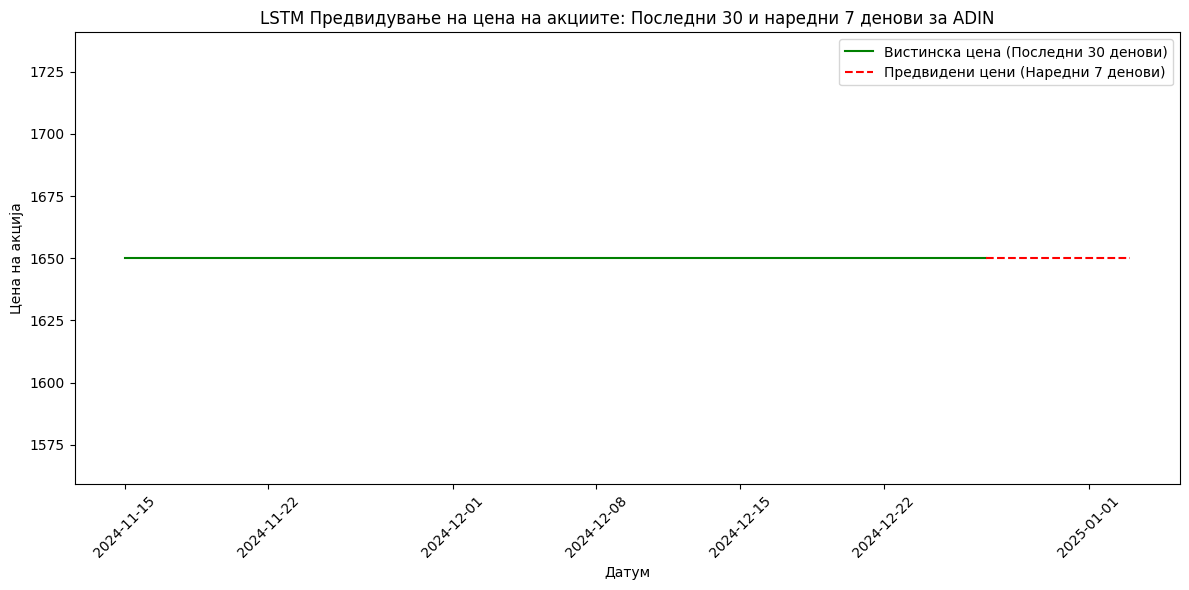

In [323]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def check_if_last_and_30th_are_similar(df, threshold=0.01):
    last_record = df.iloc[-1]
    record_30th = df.iloc[-31]
    
    columns_to_check = ['max_price', 'min_price', 'average_price', 'volume']  # Adjust columns as needed
    
    differences = abs(last_record[columns_to_check] - record_30th[columns_to_check])
    
    if all(differences < threshold):
        return True
    else:
        return False

# Assuming is_similar is determined by your check function
is_similar = check_if_last_and_30th_are_similar(df)

if is_similar:
    # If there are less than 60 records, predict the last value repeated 7 times
    last_row = df.iloc[-1]
    next_7_days = pd.date_range(last_row['date'] + timedelta(days=1), periods=7, freq='D')

    # Repeat the last known values for the next 7 days
    next_7_days_data = {
        'date': next_7_days,
        'average_price': [last_row['average_price']] * 7,
        'volume': [last_row['volume']] * 7,
        'max_price': [last_row['max_price']] * 7,
        'min_price': [last_row['min_price']] * 7
    }

    next_7_days_df = pd.DataFrame(next_7_days_data)

    # Get the last 30 days of actual data
    actual_dates_last_30 = df['date'].iloc[-30:].values  # Assuming df is your main data DataFrame
    y_test_last_30 = df['average_price'].iloc[-30:].values  # Assuming 'average_price' is the column you want

    # Plotting the last 30 days and the predicted next 7 days
    plt.figure(figsize=(12, 6))

    # Plot actual prices for the last 30 days
    plt.plot(actual_dates_last_30, y_test_last_30, label='Вистинска цена (Последни 30 денови)', color='green')

    # Add the last actual date and value to the predicted data
    next_dates_with_connection = [actual_dates_last_30[-1]] + list(next_7_days_df['date'])  # Add last actual date
    next_7_days_predictions_with_connection = [y_test_last_30[-1]] + list(next_7_days_df['average_price'])  # Add last actual price

    # Plot the predicted prices for the next 7 days
    plt.plot(next_dates_with_connection, next_7_days_predictions_with_connection, label="Предвидени цени (Наредни 7 денови)", color='green', linestyle='--')

    # Add labels and title
    plt.xlabel('Датум')
    plt.ylabel('Цена на акција')
    plt.title(f'LSTM Предвидување на цена на акциите: Последни 30 и наредни 7 денови за {company_code}')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add the legend
    plt.legend()

    # Tight layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()
